# Explore the EarlyConvNet model class

In [2]:
from src.models import early_convnet

2024-01-01 20:54:00.263133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Imports

In [3]:
import src.data.datasets.deep_globe_2018

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [4]:
## Pipeline
batch_size_images = 1
batch_size_patches = 1
img_size = 612
patch_size = 80
patch_size_annotation = 2
patch_stride = 32

## Training
epochs = 3
class_weights = {
        0: 6.070,    # urban_land
        1: 1.,       # agriculture_land
        2: 5.559,    # rangeland
        3: 4.128,    # forest_land
        4: 15.176,   # water
        5: 9.244,    # barren_land
        6: 100.       # unknown - Note: not to scale with respect to the others but not that important for the overall classification
}

## Utility functions

In [5]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [6]:
def rgb_to_index(image):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]
    
    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all(tf.equal(image, colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.uint8)
    indexed = tf.math.argmax(one_hot_map, axis=2)
    indexed = tf.cast(indexed, dtype=tf.uint8)
    indexed = tf.expand_dims(indexed, -1)

    return indexed

In [7]:
def reduce_mode(tensor):
    y, idx, count = tf.unique_with_counts(tensor)
    mode = y[tf.argmax(count)]
    return mode

In [11]:
def load_patches_labels(datapoint, image_size, patch_size, patch_size_annotation, stride):
    crop_fraction = patch_size_annotation / patch_size
    
    images = tf.image.resize(datapoint['image'], (image_size, image_size))
    img_patches = tf.image.extract_patches(
        images = images,
        sizes = [1, patch_size, patch_size, 1],
        strides = [1, stride, stride, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
    )
    img_patches_flat = tf.reshape(img_patches, shape=(-1, patch_size, patch_size, 3))

    annotations = tf.map_fn(rgb_to_index, datapoint['segmentation_mask'])
    annotations = tf.image.resize(annotations, (image_size, image_size), method='nearest')

    ann_patches = tf.image.extract_patches(
        images = annotations,
        sizes = [1, patch_size, patch_size, 1],
        strides = [1, stride, stride, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
    )
    ann_patches_flat = tf.reshape(ann_patches, shape=(-1, patch_size, patch_size, 1))
    central_pixels = tf.image.central_crop(ann_patches_flat, crop_fraction)
    dim = tf.reduce_prod(tf.shape(central_pixels)[1:])
    central_pixels = tf.reshape(central_pixels, [-1, dim])

    pixel_category_idx = tf.map_fn(reduce_mode, central_pixels)
    # print(central_pixels)
    # pixel_category_idx = tf.reduce_max(central_pixels, axis=1) # reduce_mode is probably preferred but I chose a simpler implementation

    img_patches_flat = normalize(img_patches_flat)
    pixel_category_one_hot = tf.one_hot(
        pixel_category_idx,
        depth = 7, # TODO: make depth configurable
        on_value = 1,
        off_value = -1
    )

    return img_patches_flat, pixel_category_one_hot

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

## Optimizer, loss function, dataset and model

### Dataset

In [13]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    name='deep_globe_2018',
    download=False,
    with_info=True,
    split=['all_images[:7]', 'all_images[7:9]', 'all_images[9:10]']
)
train_batches = (
    ds_train
    .batch(batch_size_images)
    .map(lambda x: load_patches_labels(x, img_size, patch_size, patch_size_annotation, patch_stride), num_parallel_calls=tf.data.AUTOTUNE)
    .unbatch() # Flatten the batches for training
    .batch(batch_size_patches) # Rebatch patches as desired
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
validation_batches = (
    ds_valid
    .batch(batch_size_images)
    .map(lambda x: load_patches_labels(x, img_size, patch_size, patch_size_annotation, patch_stride), num_parallel_calls=tf.data.AUTOTUNE)
    .unbatch() # Flatten the batches for training
    .batch(batch_size_patches) # Rebatch patches as desired
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_batches = (
    ds_test
    .batch(batch_size_images)
    .map(lambda x: load_patches_labels(x, img_size, patch_size, patch_size_annotation, patch_stride), num_parallel_calls=tf.data.AUTOTUNE)
    ## unbatching not required for testing
    # .unbatch() # Flatten the batches for training
    # .batch(batch_size_patches) # Rebatch patches as desired
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)    
# ds_info

2024-01-01 20:56:21.676489: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


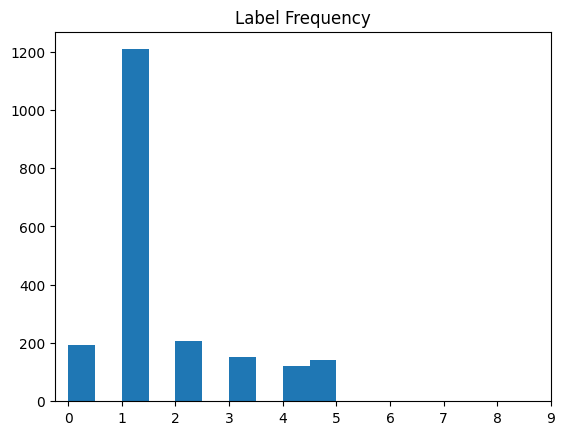

In [17]:
import numpy as np
import matplotlib.pyplot as plt

vals = np.fromiter(train_batches.map(lambda x, y: tf.argmax(y, axis=1)), float)

plt.hist(vals)
plt.xticks(range(10))
plt.title('Label Frequency')
plt.show()

In [22]:
np.unique(vals, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]), array([ 194, 1208,  206,  151,  121,  143]))

In [8]:
# train_batches = (
#     ds_train
#     .take(1)
#     .batch(1)
#     .map(lambda x: load_patches_labels(x, img_size, patch_size, patch_size_annotation, patch_stride), num_parallel_calls=tf.data.AUTOTUNE)
#     .prefetch(buffer_size=tf.data.AUTOTUNE)
# )
# for i, m in train_batches.take(1):
#     sample_images = i[1190:1210]
#     sample_masks = m[1190:1210]
#     print(i.shape, m.shape)
#     # samples = list(zip(sample_images, sample_masks))

### Loss function

In [106]:
loss_fn = tf.keras.losses.MeanSquaredError()

### Optimizer

In [107]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

### Model

In [108]:
model = early_convnet.EarlyConvnet()
model.build((None, patch_size, patch_size, 3))
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['mse']
)

In [109]:
model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    class_weight=class_weights
    #TODO: considering using class weights
)

Epoch 1/3
2023/2023 [==============================] - 34s 15ms/step - loss: 4.3885 - mse: 1.2522 - val_loss: 1.2646 - val_mse: 1.2646
Epoch 2/3
2023/2023 [==============================] - 32s 15ms/step - loss: 4.3564 - mse: 1.2475 - val_loss: 1.2593 - val_mse: 1.2593
Epoch 3/3
2023/2023 [==============================] - 33s 15ms/step - loss: 4.3467 - mse: 1.2418 - val_loss: 1.2501 - val_mse: 1.2501


In [112]:
for i,m in test_batches.take(1):
    y = model.predict(i)
    mask = tf.reshape(tf.argmax(input=y, axis=3), shape=(1, 17, 17, 1))
    display(mask)

10/10 [==============================] - 0s 29ms/step


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 34969 values, but the requested shape has 289 [Op:Reshape]

In [23]:
# model.build((None, patch_size, patch_size, 3))
# raw_input = (patch_size, patch_size, 3)
# y = model(tf.ones(shape=(8,*raw_input))) 
model.build_graph(raw_input).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 3)]       0         
                                                                 
 C1 (Conv2D)                 (None, 34, 34, 6)         888       
                                                                 
 S2 (Subsampling)            (None, 17, 17, 6)         12        
                                                                 
 C3 (Conv2D)                 (None, 12, 12, 16)        3472      
                                                                 
 S4 (Subsampling)            (None, 6, 6, 16)          32        
                                                                 
 C5 (Conv2D)                 (None, 1, 1, 40)          23080     
                                                                 
 F6 (Dense)                  (None, 1, 1, 7)           287 

## Training loop

In [46]:
# Source: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch (last accessed 31.12.2023)

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    
    for step, (img_batch_train, cat_batch_train) in enumerate(train_batches):
        with tf.GradientTape() as tape:
            logits = model(img_batch_train, training=True)
            print(logits.shape)
            print(cat_batch_train.shape)
            loss_value = loss_fn(cat_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))


Start of epoch 0
(8, 1, 1, 7)
(8, 7)


KeyError: 'The optimizer cannot recognize variable early_convnet_3/C1/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.SGD.'